# Implementation of the squeezed laser

In [66]:
import math as math
import numpy as np
import scipy as scipy
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import sys
import os

from qutip import *
from src_2_0 import *

In [67]:
def make_rho(N,ket,bra):
    return tensor(identity(N),ket*bra.dag())

In [68]:
def H_def(N,a,g,e,r_ket,s_ket,delta_c,Delta_1,Delta_s,Delta_r,g_s,g_r,Omega_s,Omega_r,omega=0,phi=0): # Defines the Hamiltonian of the system. It considers a coupling between a photonic cavity and a one-atom subsystem.
    H_cav = delta_c*a.dag()*a+Delta_1*make_rho(N,e,e)+Delta_r*make_rho(N,r_ket,r_ket)+Delta_s*make_rho(N,s_ket,s_ket)
    H_int = np.conj(g_s)*a.dag()*make_rho(N,e,s_ket)+g_s*a*make_rho(N,s_ket,e)+np.conj(g_r)*a.dag()*make_rho(N,g,r_ket)+g_r*a*make_rho(N,r_ket,g)
    H_dr = (Omega_s/2)*(make_rho(N,g,s_ket)+make_rho(N,s_ket,g))+(Omega_r/2)*(make_rho(N,e,r_ket)+make_rho(N,r_ket,e))+omega*(a*np.exp(-1j*phi)+a.dag()*np.exp(1j*phi))
    return H_cav+H_int+H_dr

In [69]:
def H_eff(N,a,g,e,g_0,r,theta,omega=0,phi=0): # Defines the Hamiltonian of the system. It considers a coupling between a photonic cavity and a one-atom subsystem.
    return g_0*(make_rho(N,g,e)*(np.cosh(r)*a.dag()+np.exp(1j*theta)*np.sinh(r)*a)+make_rho(N,e,g)*(np.cosh(r)*a+np.exp(-1j*theta)*np.sinh(r)*a.dag()))+omega*(a*np.exp(-1j*phi)+a.dag()*np.exp(1j*phi))

In [70]:
def Lops_def(N,a,g,e,s_ket,k,P,eta,gamma): # Defines the system's collapse (Lindblad) operators, one that represents incoherent pumping and other that describes photon loss.
    return [np.sqrt(P)*make_rho(N,e,g),np.sqrt(k*(1+eta))*a,np.sqrt(gamma)*make_rho(N,e,s_ket)]

#### Parameters

In [71]:
### General parameters ###

N = 60 # Dimension of the Hilbert space of the cavity
n_q = 20 # Photon saturation number
C = np.linspace(1.6,2,2) # Cooperativity (equal to the pumping parameter p)
eta = 0 # Photon loss due to other decay channels
gamma = 0

### Hamiltonian parameters ###

g_0 = 10**(-5) # Light-matter coupling
Delta = 1 # Detunings Delta_s = Delta_r
r = 0.75 # Squeezing parameter
theta = np.pi # Squeezing angle
Omega_r = 1e-2

### Symmetry broken parameters ###

omega = 0 # Amplitude of the coherent driving with well defined phase
phi = 0 # Fixed phase

#### Parameter-dependent quantities

In [72]:
k = g_0*np.sqrt(2/(C*n_q)) # Photon decay rate
P = 2*n_q*k # Incoherent pumping
C_s = C*np.cosh(r)**2 # Squeezed cooperativity (equal to the squeezed pumping parameter p_s)

In [73]:
Omega_s = np.tanh(r)*Omega_r
delta_c = (4*g_0**2*np.cosh(r)**2*Delta)/Omega_r**2
Delta_1 = (Omega_r**2/(4*Delta))*(1-np.tanh(r)**2)
g_r = -2*Delta*g_0*np.cosh(r)/Omega_r
g_s = g_r*np.exp(1j*theta)

In [74]:
print(Delta,Omega_s,Omega_r,delta_c,Delta_1,g_r,g_s) # We want Delta_c to be small compared to g_0*np.cosh(r)

1 0.006351489523872873 0.01 6.704819230486496e-06 1.4914645207033286e-05 -0.0025893665693536897 (0.0025893665693536897-3.171059480978159e-19j)


In [75]:
P

array([1.00000000e-04, 8.94427191e-05])

#### Operators

In [76]:
a = tensor(destroy(N),identity(4)) # Annihilation operator
g = basis(4,0) # Atomic states
e = basis(4,1)
s_ket = basis (4,2)
r_ket = basis(4,3)

In [77]:
a_eff = tensor(destroy(N),identity(2))
g_eff = basis(2,0)
e_eff = basis(2,1)

#### Hamiltonian

In [78]:
H = H_def(N,a,g,e,r_ket,s_ket,delta_c,Delta_1,Delta,Delta,g_s,g_r,Omega_s,Omega_r,omega=0,phi=0) # Iniatilize the hamiltonian for the chosen parameters

In [79]:
Heff = H_eff(N,a_eff,g_eff,e_eff,g_0,r,theta)

#### Steady-states

In [80]:
rho_ss = [] # Steady states of the system

for i in tqdm(range(np.size(C))):
     rho_ss.append(steadystate(H,Lops_def(N,a,g,e,s_ket,k[i],P[i],eta,gamma))) # Calculate the density matrix of the steady states

100%|██████████| 2/2 [00:14<00:00,  7.18s/it]


In [81]:
rho_eff = [] # Steady states of the effective system

for i in tqdm(range(np.size(C))):
     rho_eff.append(steadystate(Heff,Lops_def(N,a_eff,g_eff,e_eff,e_eff,k[i],P[i],eta,0))) # Calculate the density matrix of the steady states

100%|██████████| 2/2 [00:00<00:00,  4.71it/s]


In [82]:
print(np.sum([expect(a**2,rho_ss[i])for i in range(np.size(C))]))
print(np.sum([expect(a.dag()**2,rho_ss[i])for i in range(np.size(C))]))

(4.611938274467533-0.18734047386706382j)
(4.611938274467533+0.18734047386706382j)


In [83]:
expect(a**2,rho_ss[0])
expect(a.dag()**2,rho_ss[0])

(2.5551732883052347+0.09414087580571913j)

### 1. Photon population

In [84]:
n = np.zeros(np.size(C)) # Photon population
n_eff = np.zeros(np.size(C)) # Photon population

for i in range(np.size(C)):   
    n[i] = expect(a.dag()*a,rho_ss[i]) # Calculate the photon population
    n_eff[i] = expect(a_eff.dag()*a_eff,rho_eff[i]) # Calculate the photon population

In [85]:
n_eff

array([15.44993814, 18.64139477])

In [86]:
### General result of the mean field solution ###
'''
R = k/P # Rename some constantes for a more compact expression
mu = -(Delta_c+R*Delta_0)/(R+1)
g_tilda = g_0*np.cosh(r)
N_S = 0.5+(1/(2*g_tilda**2))*(R*((Delta_c-Delta_0)/(R+1))**2+(P*k)/4)
mfs = ((1/R)*(1-N_S)*np.cosh(2*r)+np.sinh(r)**2)*np.heaviside((1/R)*(1-N_S)*np.cosh(2*r)+np.sinh(r)**2,0) # Mean-field solution
'''

'\nR = k/P # Rename some constantes for a more compact expression\nmu = -(Delta_c+R*Delta_0)/(R+1)\ng_tilda = g_0*np.cosh(r)\nN_S = 0.5+(1/(2*g_tilda**2))*(R*((Delta_c-Delta_0)/(R+1))**2+(P*k)/4)\nmfs = ((1/R)*(1-N_S)*np.cosh(2*r)+np.sinh(r)**2)*np.heaviside((1/R)*(1-N_S)*np.cosh(2*r)+np.sinh(r)**2,0) # Mean-field solution\n'

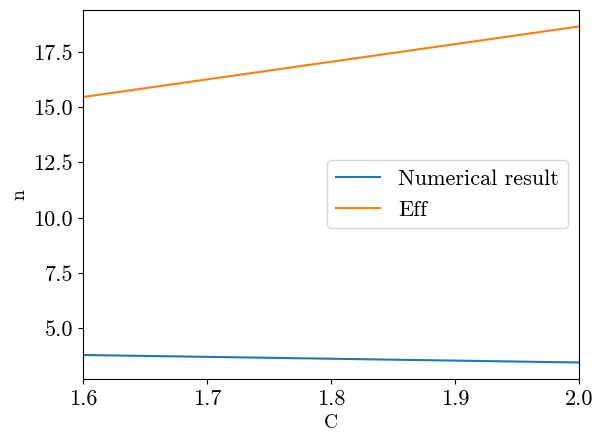

In [87]:
plt.plot(C,n,label='Numerical result')
plt.plot(C,n_eff,label='Eff')
#plt.plot(C,mfs,label='Mean field prediction')
plt.xlim([np.min(C),np.max(C)])
#plt.ylim([0,0.001])
plt.xlabel('C',fontsize=14)
plt.ylabel('n',fontsize=14)
plt.legend()
plt.show()

In [88]:
n[-1]

3.4449317309984537

In [89]:
quad_ang = np.pi-(theta)/2 # Quadrature angle that specifies the field's quadrature to measure
X_ang = a*np.exp(-1j*quad_ang)+a.dag()*np.exp(1j*quad_ang) # Chosen quadrature operator

In [90]:
fluc = np.zeros(np.size(C),dtype='complex')

for i in range(np.size(C)):
    fluc[i] = expect(X_ang**2,rho_ss[i])-expect(X_ang,rho_ss[i])**2 # Calculate quadrature fluctuations

c:\Users\rodri\anaconda3\envs\myenv\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\rodri\anaconda3\envs\myenv\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


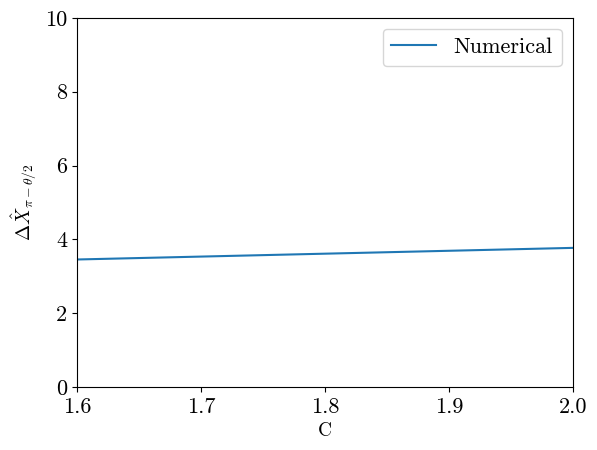

In [91]:
plt.plot(C,fluc,label='Numerical')
plt.xlim([np.min(C),np.max(C)])
plt.ylim([0,10])
plt.xlabel('C',fontsize=14)
plt.ylabel(r'$\Delta\hat{X}_{\pi-\theta/2}$',fontsize=14)
plt.legend()
plt.show()

### 2. Wigner distribution

In [92]:
index = 0 # Select the value of the cooperativity by writting its index

In [93]:
C[0]

1.6

In [94]:
P

array([1.00000000e-04, 8.94427191e-05])

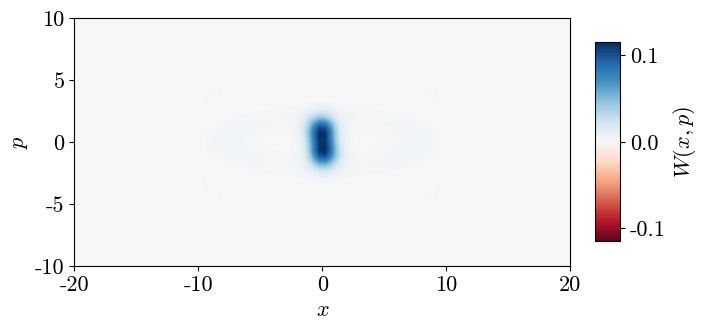

In [95]:
wr = wigner_rep(rhos = rho_ss[index]) # Initialize the calculation with its parameters
x_lim = 20 # X-Axis limits
p_lim = 10 # P-Axis limits
wr.wigner_plot(x_lim,p_lim) # Calculate the Wigner function

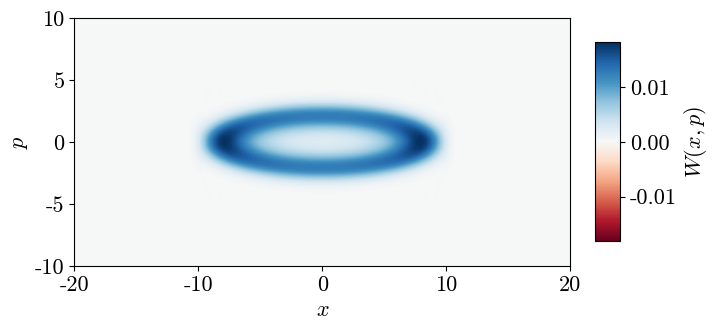

In [63]:
wr = wigner_rep(rhos = rho_eff[0]) # Initialize the calculation with its parameters
x_lim = 20 # X-Axis limits
p_lim = 10 # P-Axis limits
wr.wigner_plot(x_lim,p_lim) # Calculate the Wigner function

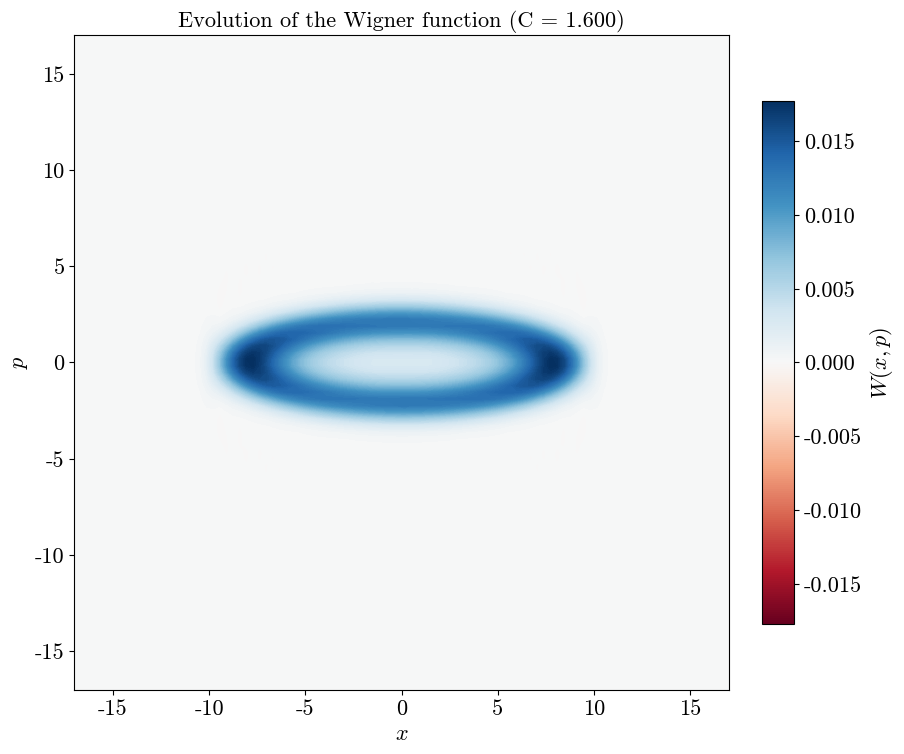

In [64]:
wigner_rep(rhos = rho_ss).wigner_animation(17,17,C,figname = '4LS_Var_C',speed = 1000, mrname = 'C') # Create an animation for the whole range of C